In [1]:
import os
os.chdir('/home/renwh/gaze/renwh/caffe_with_cudnnv3/')

import sys
sys.path.insert(0,'./python')
import caffe

from pylab import *
%matplotlib inline


caffe.set_device(0)
caffe.set_mode_gpu()
solver = caffe.SGDSolver('examples/mymodel/03/lenet_solver.prototxt')

#You can choose to load your model status
#solver.restore('examples/mymodel/03/lenet_iter_1001.solverstate')

In [2]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (1000, 1, 36, 60)),
 ('label', (1000, 6)),
 ('gaze', (1000, 3)),
 ('headpose', (1000, 3)),
 ('conv1', (1000, 20, 32, 56)),
 ('pool1', (1000, 20, 16, 28)),
 ('conv2', (1000, 40, 14, 26)),
 ('pool2', (1000, 40, 7, 13)),
 ('conv3', (1000, 60, 4, 10)),
 ('pool3', (1000, 60, 2, 5)),
 ('flatdata', (1000, 600)),
 ('cat', (1000, 603)),
 ('ip1', (1000, 300)),
 ('ip2', (1000, 3)),
 ('loss', ())]

In [3]:
# just print the weight sizes (not biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (20, 1, 5, 5)),
 ('conv2', (40, 20, 3, 3)),
 ('conv3', (60, 40, 4, 4)),
 ('ip1', (300, 603)),
 ('ip2', (3, 300))]

In [4]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'loss': array(0.49637848138809204, dtype=float32)}

[[ -2.44513273e-01   5.20949736e-02  -9.68245506e-01  -5.07045567e-01
   -1.12138920e-01  -2.90884897e-02]
 [ -7.41908699e-02   2.27922529e-01  -9.70848620e-01  -1.28387764e-01
    1.65355857e-02   1.06296828e-03]
 [ -1.74087971e-01   3.04691344e-02  -9.84258592e-01  -9.52000245e-02
   -3.14195365e-01  -1.50917871e-02]
 [ -2.49744281e-02   1.77879885e-01  -9.83735263e-01  -7.38587156e-02
   -1.21144764e-02  -4.47588827e-04]
 [ -1.61419377e-01   5.79187945e-02  -9.85184848e-01  -1.06810793e-01
    1.42905980e-01   7.65229668e-03]
 [ -1.52415037e-01   2.09456533e-01  -9.65866268e-01  -5.29863574e-02
   -1.14266567e-01  -3.03129526e-03]
 [ -1.76816806e-02   6.62708879e-02  -9.97644961e-01  -6.35477304e-02
   -2.95568883e-01  -9.46362782e-03]
 [  1.79661021e-01   2.34958977e-01  -9.55257118e-01  -8.40480402e-02
    1.60711512e-01   6.77234307e-03]]


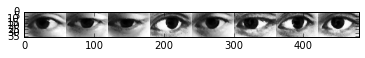

In [5]:
# we use a little trick to tile the first eight images
imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(36, 8*60), cmap='gray')
print solver.net.blobs['label'].data[:8]

In [6]:
solver.step(1)

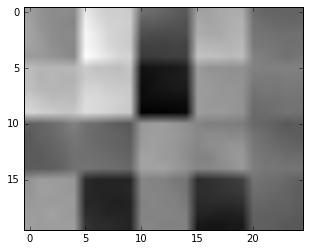

In [7]:
imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray')

Show the conv1 weights pics.


Then, I will train the model, and log some information.

In [8]:
%%time
niter = 1000
test_interval = 25
# losses will also be stored in the log
train_loss = zeros(niter)
mean_error= zeros(int(np.ceil(niter / test_interval)))
output = zeros((niter, 8, 3))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['ip2'].data[:8]
    if it % test_interval == 0:
        # caculate the square error for each gaze vector
        solver.test_nets[0].forward()
        
        num_test = 100;
        sub_error = zeros((num_test, 2))
        square_error = zeros((num_test, 2))
        sum_Euclidean_error = zeros(num_test)
        gaze_3_l = zeros((num_test, 3));
        gaze_3_i = zeros((num_test, 3));
        gaze_2_l = zeros((num_test, 2));
        gaze_2_i = zeros((num_test, 2));
        gaze_3_l = solver.test_nets[0].blobs['gaze'].data[1:num_test+1];
        gaze_3_i = solver.test_nets[0].blobs['ip2'].data[1:num_test+1];
        gaze_2_l[:,0] = np.arcsin(-1*gaze_3_l[:,1])/np.pi*180;
        gaze_2_l[:,1] = np.arctan2(-1*gaze_3_l[:,0],-1*gaze_3_l[:,2])/np.pi*180;
        gaze_2_i[:,0] = np.arcsin(-1*gaze_3_i[:,1])/np.pi*180;
        gaze_2_i[:,1] = np.arctan2(-1*gaze_3_i[:,0],-1*gaze_3_i[:,2])/np.pi*180;
        for i in range(num_test):
            sub_error[i,:] = np.subtract(gaze_2_l[i]
                                         , gaze_2_i[i])
            square_error[i,:] = np.square(sub_error[i,:])
            sum_Euclidean_error[i] = np.sum(square_error[i,:],0)
            sum_Euclidean_error[i] = np.sqrt(sum_Euclidean_error[i])
        mean_error[it // test_interval] = np.sum(sum_Euclidean_error,0)/num_test
        print 'Iteration', it, '. Mean error is', mean_error[it // test_interval]
        #print sum_Euclidean_error

Iteration 0 . Mean error is 13.9234326474
Iteration 25 . Mean error is 11.2594934318
Iteration 50 . Mean error is 10.3270079683
Iteration 75 . Mean error is 9.89319342245
Iteration 100 . Mean error is 10.8378036948
Iteration 125 . Mean error is 9.22997929507
Iteration 150 . Mean error is 10.5251261365
Iteration 175 . Mean error is 8.25300812911
Iteration 200 . Mean error is 8.1556345344
Iteration 225 . Mean error is 9.13992759846
Iteration 250 . Mean error is 7.4757226706
Iteration 275 . Mean error is 9.57288289608
Iteration 300 . Mean error is 7.18259853366
Iteration 325 . Mean error is 6.87280425734
Iteration 350 . Mean error is 7.44667383388
Iteration 375 . Mean error is 7.07850670186
Iteration 400 . Mean error is 9.12286625462
Iteration 425 . Mean error is 6.4339575769
Iteration 450 . Mean error is 7.11678537851
Iteration 475 . Mean error is 6.64223423518
Iteration 500 . Mean error is 6.53559142843
Iteration 525 . Mean error is 8.99417526264
Iteration 550 . Mean error is 6.22713383

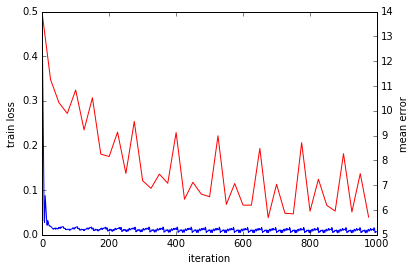

In [9]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(mean_error)), mean_error, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('mean error')

**show you the train loss curve.

--------------------------------------------------------------------------------------------------------------
1000 test pic, mean error is  5.96898011977 degree


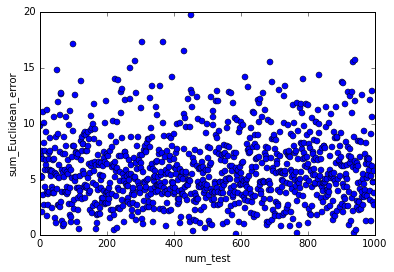

In [10]:
num_test = 1000


# (start the forward pass at conv1 to avoid loading new data)
solver.test_nets[0].forward(start='conv1')
solver.test_nets[0].forward()

#figure(figsize=(10, 5))
#imshow(solver.test_nets[0].blobs['data'].data[:num_test, 0].transpose(1, 0, 2).reshape(36, num_test*60), cmap='gray')
    
# print the label and train result
#for i in range(num_test):
#    print solver.test_nets[0].blobs['label'].data[i,:3] ,'label<->ip3', solver.test_nets[0].blobs['ip3'].data[i]

print '--------------------------------------------------------------------------------------------------------------'
# caculate the square error for each gaze vector
sub_error = zeros((num_test, 2))
square_error = zeros((num_test, 2))
sum_Euclidean_error = zeros(num_test)
gaze_3_l = zeros((num_test, 3));
gaze_3_i = zeros((num_test, 3));
gaze_2_l = zeros((num_test, 2));
gaze_2_i = zeros((num_test, 2));
gaze_3_l = solver.test_nets[0].blobs['gaze'].data[:];
gaze_3_i = solver.test_nets[0].blobs['ip2'].data[:];
gaze_2_l[:,0] = np.arcsin(-1*gaze_3_l[:,1])/np.pi*180;
gaze_2_l[:,1] = np.arctan2(-1*gaze_3_l[:,0],-1*gaze_3_l[:,2])/np.pi*180;
gaze_2_i[:,0] = np.arcsin(-1*gaze_3_i[:,1])/np.pi*180;
gaze_2_i[:,1] = np.arctan2(-1*gaze_3_i[:,0],-1*gaze_3_i[:,2])/np.pi*180;
for i in range(num_test):
    sub_error[i,:] = np.subtract(gaze_2_l[i]
                                 , gaze_2_i[i])
    square_error[i,:] = np.square(sub_error[i,:])
    sum_Euclidean_error[i] = np.sum(square_error[i,:],0)
    sum_Euclidean_error[i] = np.sqrt(sum_Euclidean_error[i])
print num_test,'test pic, mean error is ',np.sum(sum_Euclidean_error,0)/num_test,'degree'
_, ax1 = subplots()
ax1.plot(arange(num_test), sum_Euclidean_error,'bo', label='sampled')
ax1.set_xlabel('num_test')
ax1.set_ylabel('sum_Euclidean_error')
    

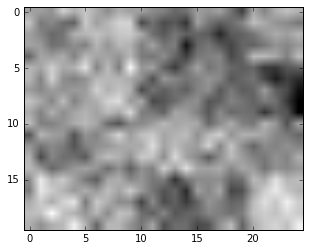

In [11]:
imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray')

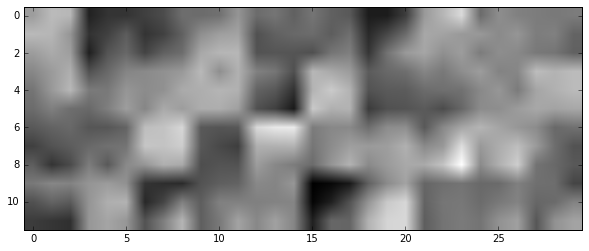

In [12]:
figure(figsize=(10, 5))
imshow(solver.net.params['conv2'][0].diff[:, 0].reshape(4, 10, 3, 3)
       .transpose(0, 2, 1, 3).reshape(4*3, 10*3), cmap='gray')

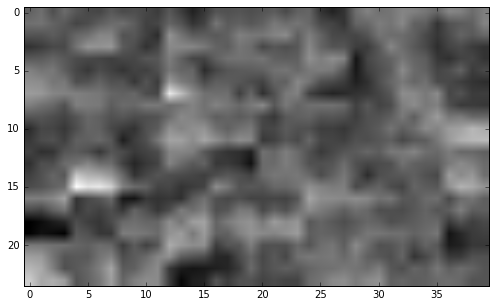

In [13]:
figure(figsize=(10, 5))
imshow(solver.net.params['conv3'][0].diff[:, 0].reshape(6, 10, 4, 4)
       .transpose(0, 2, 1, 3).reshape(6*4, 10*4), cmap='gray')

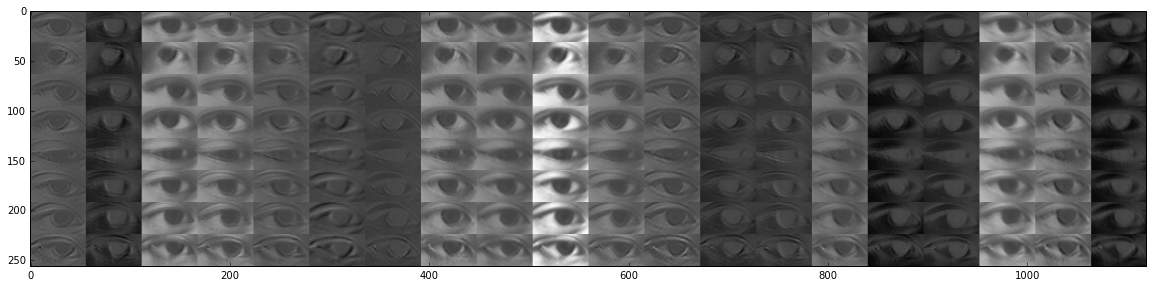

In [14]:
figure(figsize=(20, 10))
imshow(solver.test_nets[0].blobs['conv1'].data[:8, :].reshape(8,20,32,56)
           .transpose(0,2,1,3).reshape(8*32, 20*56), cmap='gray')

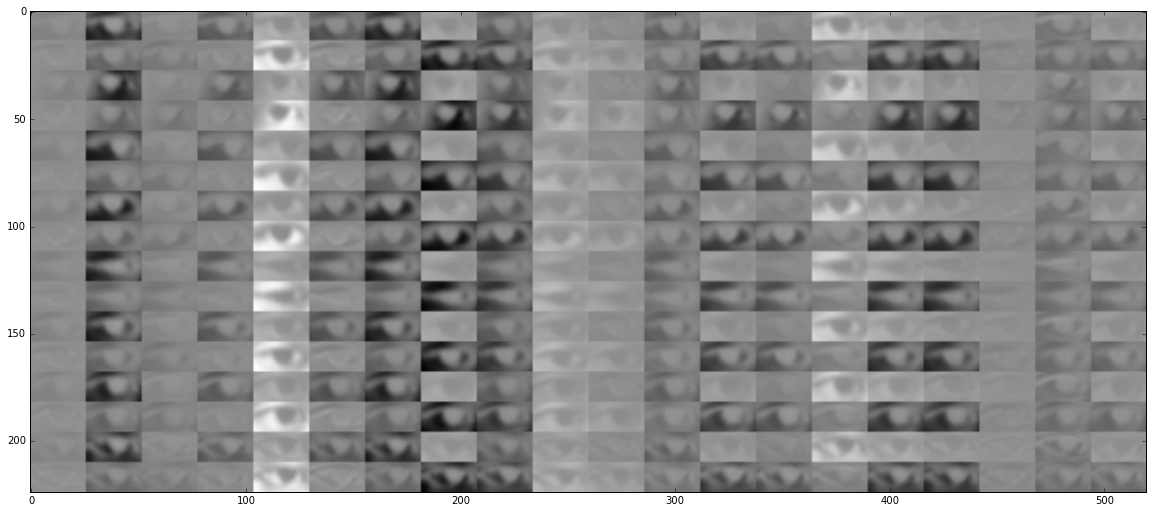

In [15]:
figure(figsize=(20, 10))
imshow(solver.test_nets[0].blobs['conv2'].data[:8, :].reshape(16, 20, 14, 26)
       .transpose(0,2,1,3).reshape(16*14, 20*26), cmap='gray')

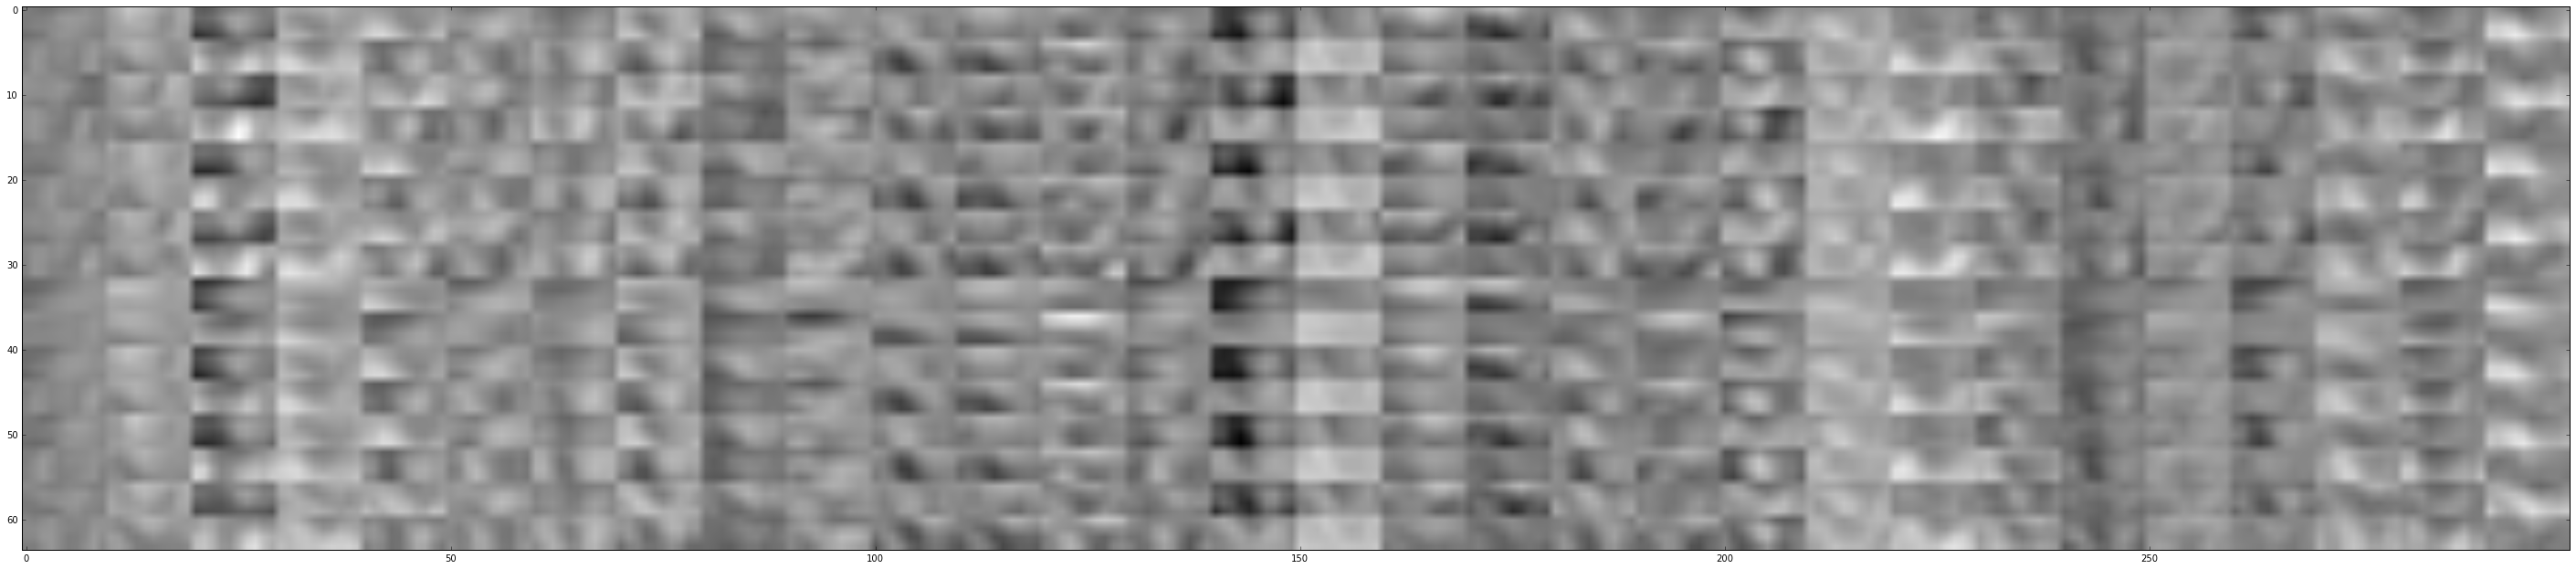

In [16]:
figure(figsize=(50, 25))
imshow(solver.test_nets[0].blobs['conv3'].data[:8, :].reshape(16, 30, 4, 10)
       .transpose(0,2,1,3).reshape(16*4, 30*10), cmap='gray')

In [18]:
#solver.net.save('my_model.caffemodel') I do not know how to use this.
solver.snapshot() #SAVE MY MODEL IN THE DIR YOU DEFINE IN SOLVER FILE.